# Customer Churn Prediction using Machine Learning

DQLab Telco is a Telco company that already has many branches spread everywhere. Since its establishment in 2019, DQLab Telco has consistently paid attention to its customer experience so that customers will not be left behind.
Even though it is only a little over 1 year old, DQLab Telco already has many customers who have switched their subscriptions to competitors. Management wants to reduce the number of churned customers by using machine learning.
Therefore, the Data Scientist team was asked to prepare the data as well as create the right prediction model to determine whether a customer will unsubscribe (churn) or not.

### Import Libraries

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

pd.options.display.max_columns = 50

### Load Dataset

In [319]:
df_load = pd.read_csv('dqlab_telco.csv')

In [320]:
df_load.shape

(7113, 22)

In [321]:
df_load.head()

,UpdatedAt,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,202006,45759018157,Female,0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,202006,45557574145,Male,0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,202006,45366876421,Male,0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,202006,45779536532,Male,0,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,202006,45923787906,Female,0,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [322]:
df_load.customerID.nunique()

7017

Criteria for correct format of customerID:
* Character length is 11-12.
* Consists of numbers only, no characters other than numbers are allowed
* Begins with the first 45 2 digits.

In [323]:
df_load['valid_id'] = df_load['customerID'].astype(str).str.match(r'(45\d{9,10})')
df_load = (df_load[df_load['valid_id'] == True]).drop('valid_id', axis = 1)
print('The result of the number of filtered Customer ID is', df_load['customerID'].count())

The result of the number of filtered Customer ID is 7006


Ensure that there are no duplicate customer ID numbers.

In [324]:
# Drop Duplicate Rows
df_load.drop_duplicates()
# Drop duplicate ID sorted by Periode
df_load = df_load.sort_values('UpdatedAt', ascending=False).drop_duplicates(['customerID'])
print('the number of customer ID that have been removed from duplicates is',df_load['customerID'].count())

the number of customer ID that have been removed from duplicates is 6993


* The number of data rows when it was first loaded was 7113 rows and 22 columns with 7017 unique ID numbers
* After checking the validity of the customer ID, the remaining 6993 rows of data

Missing Value:

In [325]:
print('Total missing values ​​data from the Churn column:', df_load['Churn'].isnull().sum())

Total missing values ​​data from the Churn column: 43


In [326]:
# Dropping all Rows with spesific column (churn)
df_load.dropna(subset=['Churn'],inplace=True)
print('Total Rows and Data columns after deleting the Missing Values ​​data are', df_load.shape)

Total Rows and Data columns after deleting the Missing Values ​​data are (6950, 22)


In [327]:
print('Status Missing Values :',df_load.isnull().values.any())
print('\nThe number of Missing Values ​​for each column is:')
print(df_load.isnull().sum().sort_values(ascending=False))

Status Missing Values : True

The number of Missing Values ​​for each column is:
tenure              99
MonthlyCharges      26
TotalCharges        15
UpdatedAt            0
DeviceProtection     0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
OnlineBackup         0
customerID           0
OnlineSecurity       0
InternetService      0
MultipleLines        0
PhoneService         0
Dependents           0
Partner              0
SeniorCitizen        0
gender               0
Churn                0
dtype: int64


In [328]:
#Handling missing values Tenure fill with 11
df_load['tenure'].fillna(11, inplace=True)

In [329]:
#Handling missing values num vars (except Tenure)
for col_name in list(['MonthlyCharges','TotalCharges']):
	median = df_load[col_name].median()
	df_load[col_name].fillna(median, inplace=True)

In [330]:
print('\nThe number of Missing Values ​​after imputing the data is:')
print(df_load.isnull().sum().sort_values(ascending=False))


The number of Missing Values ​​after imputing the data is:
UpdatedAt           0
customerID          0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
DeviceProtection    0
OnlineBackup        0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService        0
tenure              0
Dependents          0
Partner             0
SeniorCitizen       0
gender              0
Churn               0
dtype: int64


After we have handled it by deleting rows and filling in rows with a certain value, it is evident that there are no more missing values ​​in the data, as evidenced by the number of missing values ​​for each variable which has a value of 0.

Next, we will handle outliers.

In [331]:
print(df_load[['tenure','MonthlyCharges','TotalCharges']].describe())

            tenure  MonthlyCharges  TotalCharges
count  6950.000000     6950.000000   6950.000000
mean     32.477266       65.783741   2305.083460
std      25.188910       50.457871   2578.651143
min       0.000000        0.000000     19.000000
25%       9.000000       36.462500    406.975000
50%      29.000000       70.450000   1400.850000
75%      55.000000       89.850000   3799.837500
max     500.000000     2311.000000  80000.000000


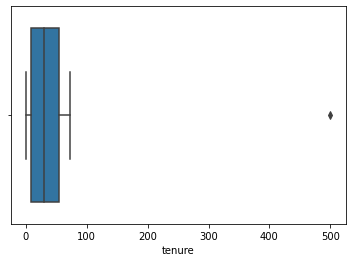

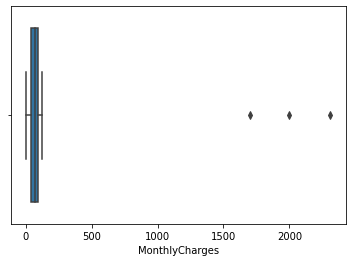

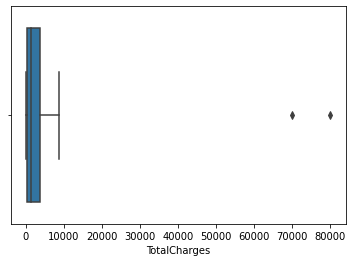

In [332]:
plt.figure()
sns.boxplot(x=df_load['tenure'])
plt.show()

plt.figure()
sns.boxplot(x=df_load['MonthlyCharges'])
plt.show()

plt.figure()
sns.boxplot(x=df_load['TotalCharges'])
plt.show()

In [333]:
# Handling with IQR
Q1 = (df_load[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.25)
Q3 = (df_load[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.75)

IQR = Q3 - Q1
maximum = Q3 + (1.5*IQR)
print('The Maximum Value of each Variable is: ')
print(maximum)
minimum = Q1 - (1.5*IQR)
print('\nThe Minimum Value of each Variable is: ')
print(minimum)
more_than = (df_load > maximum)
lower_than = (df_load < minimum)
df_load = df_load.mask(more_than, maximum, axis=1)
df_load = df_load.mask(lower_than, minimum, axis=1)

The Maximum Value of each Variable is: 
tenure             124.00000
MonthlyCharges     169.93125
TotalCharges      8889.13125
dtype: float64

The Minimum Value of each Variable is: 
tenure             -60.00000
MonthlyCharges     -43.61875
TotalCharges     -4682.31875
dtype: float64


<ipython-input-333-1ab25d200c04>:12: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  more_than = (df_load > maximum)
<ipython-input-333-1ab25d200c04>:13: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  lower_than = (df_load < minimum)


In [334]:
print('\nDistribution of data after handling Outliers: ')
print(df_load[['tenure','MonthlyCharges','TotalCharges']].describe())


Distribution of data after handling Outliers: 
            tenure  MonthlyCharges  TotalCharges
count  6950.000000     6950.000000   6950.000000
mean     32.423165       64.992201   2286.058750
std      24.581073       30.032040   2265.702553
min       0.000000        0.000000     19.000000
25%       9.000000       36.462500    406.975000
50%      29.000000       70.450000   1400.850000
75%      55.000000       89.850000   3799.837500
max     124.000000      169.931250   8889.131250


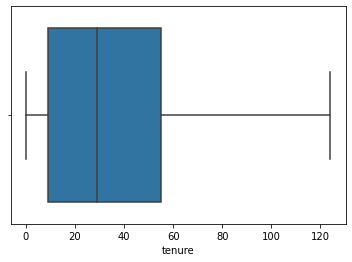

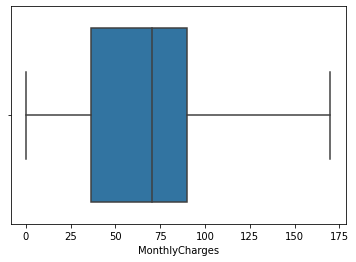

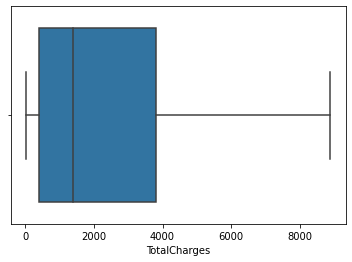

In [335]:
plt.figure()
sns.boxplot(x=df_load['tenure'])
plt.show()

plt.figure()
sns.boxplot(x=df_load['MonthlyCharges'])
plt.show()

plt.figure()
sns.boxplot(x=df_load['TotalCharges'])
plt.show()

After handling the outliers, and looking at the distribution of the data, it can be seen that there are no more outlier values.

Next, we will detects non-standard values

In [336]:
for col_name in list(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Churn']):
	print('\nUnique Values Count \033[1m' + 'Before Standardized \033[0m Variable',col_name)
	print(df_load[col_name].value_counts())


Unique Values Count Before Standardized  Variable gender
Male         3499
Female       3431
Wanita         14
Laki-Laki       6
Name: gender, dtype: int64

Unique Values Count Before Standardized  Variable SeniorCitizen
0    5822
1    1128
Name: SeniorCitizen, dtype: int64

Unique Values Count Before Standardized  Variable Partner
No     3591
Yes    3359
Name: Partner, dtype: int64

Unique Values Count Before Standardized  Variable Dependents
No     4870
Yes    2060
Iya      20
Name: Dependents, dtype: int64

Unique Values Count Before Standardized  Variable PhoneService
Yes    6281
No      669
Name: PhoneService, dtype: int64

Unique Values Count Before Standardized  Variable MultipleLines
No                  3346
Yes                 2935
No phone service     669
Name: MultipleLines, dtype: int64

Unique Values Count Before Standardized  Variable InternetService
Fiber optic    3057
DSL            2388
No             1505
Name: InternetService, dtype: int64

Unique Values Count Befor

* `Gender` (Female, Male, Wanita, Laki-Laki), whose values ​​can be standardized to (Female, Male) because they have the same meaning.
* `Dependents` (Yes, No, Iya), whose values ​​can be standardized to (Yes, No) because they have the same meaning.
* `Churn` (Yes, No, Churn), whose value can be standardized to (Yes, No) because it has the same meaning.

In [337]:
df_load = df_load.replace(['Wanita','Laki-Laki','Churn','Iya'],['Female','Male','Yes','Yes'])
# Masukkan variable
for col_name in list(['gender','Dependents','Churn']):
	print('\nUnique Values Count \033[1m' + 'After Standardized \033[0mVariable',col_name)
	print(df_load[col_name].value_counts())


Unique Values Count After Standardized Variable gender
Male      3505
Female    3445
Name: gender, dtype: int64

Unique Values Count After Standardized Variable Dependents
No     4870
Yes    2080
Name: Dependents, dtype: int64

Unique Values Count After Standardized Variable Churn
No     5114
Yes    1836
Name: Churn, dtype: int64


After we standardize the value, and we observe again the form of the data, it is well standardized for the unique value.

### Exploratory Data Analysis (EDA)

Visualize Churn Percentage

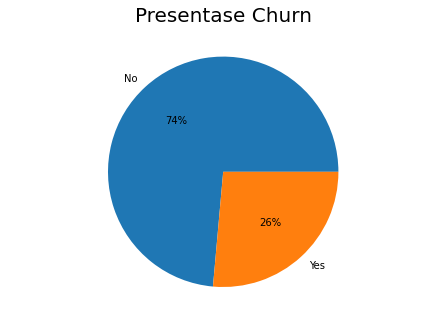

In [338]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = ['No','Yes']
churn = df_load.Churn.value_counts()
ax.pie(churn, labels=labels, autopct='%.0f%%')
plt.title("Presentase Churn", fontsize=20)
plt.show()

overall distribution of data customers do not churn, with detail Churn as much as 26% and No Churn as much as 74%

Next, we will visualize numeric variable

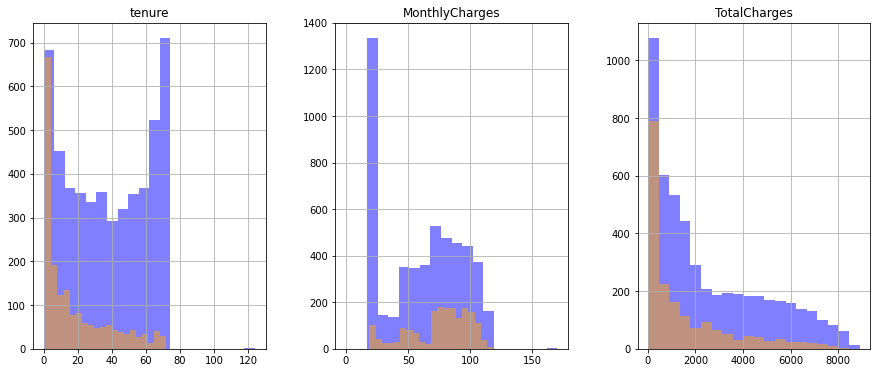

In [339]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

df_load[df_load.Churn == 'No'][numerical_features].hist(bins=20, color='blue', alpha=0.5, ax=ax)
df_load[df_load.Churn == 'Yes'][numerical_features].hist(bins=20, color='orange', alpha=0.5, ax=ax)
plt.show()

* `MonthlyCharges` there is a tendency that the smaller the value of the monthly fee charged, the smaller the tendency to make Churn.
* `TotalCharges` has no trend whatsoever towards Churn customers.
* `Tenure` there is a tendency that the longer a customer subscribes, the smaller the tendency to churn.

Next, we will visualize kategoric variable

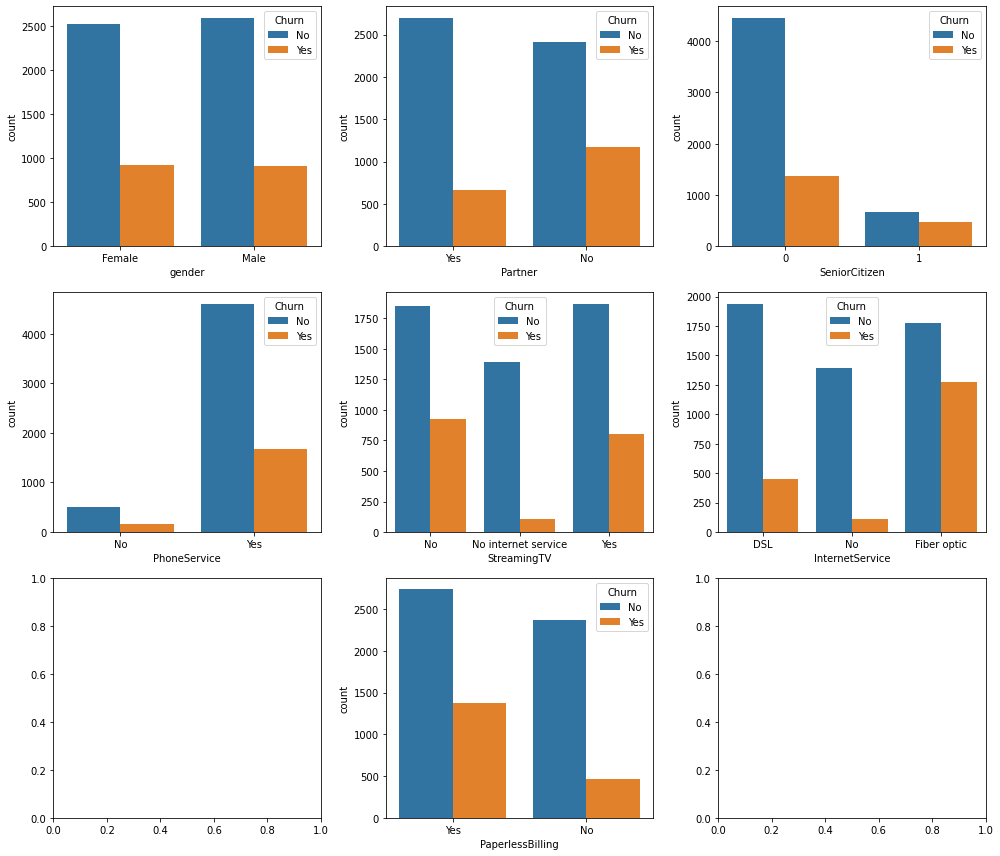

In [340]:
fig, ax = plt.subplots(3, 3, figsize=(14, 12))
sns.countplot(data=df_load, x='gender', hue='Churn', ax=ax[0][0])
sns.countplot(data=df_load, x='Partner', hue='Churn', ax=ax[0][1])
sns.countplot(data=df_load, x='SeniorCitizen', hue='Churn', ax=ax[0][2])
sns.countplot(data=df_load, x='PhoneService', hue='Churn', ax=ax[1][0])
sns.countplot(data=df_load, x='StreamingTV', hue='Churn', ax=ax[1][1])
sns.countplot(data=df_load, x='InternetService', hue='Churn', ax=ax[1][2])
sns.countplot(data=df_load, x='PaperlessBilling', hue='Churn', ax=ax[2][1])
plt.tight_layout()
plt.show()

* There is no significant difference for people who churn in terms of gender and PhoneService
* There is a tendency that people who do churn are people who don't have partners (partner: No), people whose status is senior citizens (SeniorCitizen: Yes), people who have TV streaming services (StreamingTV: Yes), people who have Internet service (internetService: Yes) and people whose bills are paperless (PaperlessBilling: Yes)

### Pre-Processing Data

In [341]:
#Remove the unnecessary columns customerID & UpdatedAt
cleaned_df = df_load.drop(['customerID','UpdatedAt','Dependents','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingMovies','Contract','PaymentMethod'], axis=1)
print(cleaned_df.head())

      gender  SeniorCitizen Partner  tenure PhoneService InternetService  \
0     Female              0     Yes     1.0           No             DSL   
4727    Male              0     Yes    60.0          Yes              No   
4738    Male              0      No     5.0          Yes     Fiber optic   
4737  Female              0     Yes    72.0          Yes     Fiber optic   
4736  Female              0     Yes    56.0          Yes             DSL   

              StreamingTV PaperlessBilling  MonthlyCharges  TotalCharges Churn  
0                      No              Yes           29.85         29.85    No  
4727  No internet service              Yes           20.50       1198.80    No  
4738                  Yes               No          104.10        541.90   Yes  
4737                  Yes              Yes          115.50       8312.75    No  
4736                  Yes               No           81.25       4620.40    No  


In [342]:
#Convert all the non-numeric columns to numerical data types
for column in cleaned_df.columns:
	if cleaned_df[column].dtype == np.number: continue
	# Perform encoding for each non-numeric column
	cleaned_df[column] = LabelEncoder().fit_transform(cleaned_df[column])
print(cleaned_df.describe())

            gender  SeniorCitizen      Partner       tenure  PhoneService  \
count  6950.000000    6950.000000  6950.000000  6950.000000   6950.000000   
mean      0.504317       0.162302     0.483309    32.423165      0.903741   
std       0.500017       0.368754     0.499757    24.581073      0.294967   
min       0.000000       0.000000     0.000000     0.000000      0.000000   
25%       0.000000       0.000000     0.000000     9.000000      1.000000   
50%       1.000000       0.000000     0.000000    29.000000      1.000000   
75%       1.000000       0.000000     1.000000    55.000000      1.000000   
max       1.000000       1.000000     1.000000   124.000000      1.000000   

       InternetService  StreamingTV  PaperlessBilling  MonthlyCharges  \
count      6950.000000  6950.000000       6950.000000     6950.000000   
mean          0.872950     0.985180          0.591942       64.992201   
std           0.737618     0.885069          0.491509       30.032040   
min           

<ipython-input-342-a0c1889be771>:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if cleaned_df[column].dtype == np.number: continue


the dataset is divided into 2 parts (70% training & 30% testing) based on the predictor variable (y) and the target (Y)

In [343]:
# Predictor dan target
X = cleaned_df.drop('Churn', axis = 1)
y = cleaned_df['Churn']
# Splitting train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Print according to the expected result
print('The number of rows and columns of x_train is:', x_train.shape,', while the number of rows and columns of y_train is:', y_train.shape)
print('The percentage of Churn in the Training data is:')
print(y_train.value_counts(normalize=True))
print('The number of rows and columns of x_test is:', x_test.shape,', while the number of rows and columns of y_test is:', y_test.shape)
print('The percentage of Churn in the Testing data is:')
print(y_test.value_counts(normalize=True))

The number of rows and columns of x_train is: (4865, 10) , while the number of rows and columns of y_train is: (4865,)
The percentage of Churn in the Training data is:
0    0.734841
1    0.265159
Name: Churn, dtype: float64
The number of rows and columns of x_test is: (2085, 10) , while the number of rows and columns of y_test is: (2085,)
The percentage of Churn in the Testing data is:
0    0.738129
1    0.261871
Name: Churn, dtype: float64


### Modelling

#### Logistic Regression

In [344]:
log_model = LogisticRegression().fit(x_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [345]:
# Train
y_train_pred = log_model.predict(x_train)

# Print classification report
print('Classification Report Training Model (Logistic Regression) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3575
           1       0.65      0.49      0.56      1290

    accuracy                           0.80      4865
   macro avg       0.74      0.70      0.71      4865
weighted avg       0.78      0.80      0.79      4865



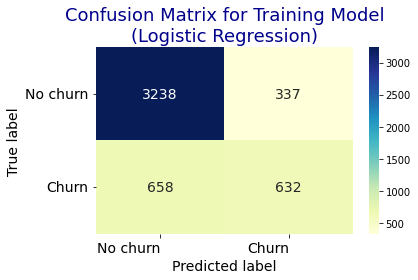

In [346]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Training Model\n(Logistic Regression)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

In [347]:
# Predict
y_test_pred = log_model.predict(x_test)

# Print classification report 
print('Classification Report Testing Model (Logistic Regression) :')
print(classification_report(y_test, y_test_pred))

Classification Report Testing Model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1539
           1       0.64      0.48      0.55       546

    accuracy                           0.79      2085
   macro avg       0.74      0.69      0.71      2085
weighted avg       0.78      0.79      0.78      2085



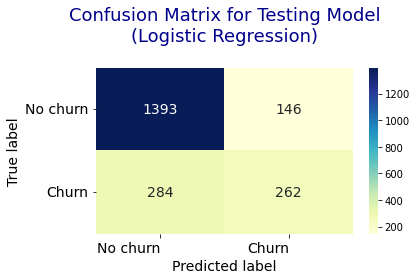

In [348]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)),('No churn','Churn'),('No churn','Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size':14},fmt='d',cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0,ha='right',fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation=0,ha='right',fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

* From the training data it can be seen that the model is able to predict the data with an accuracy of 80%
* From the data testing it can be seen that the model is able to predict the data by producing an accuracy of 79%

#### Random Forest Classifier

In [349]:
rdf_model = RandomForestClassifier().fit(x_train, y_train)

In [350]:
#Train
y_train_pred = rdf_model.predict(x_train)
print('Classification Report Training Model (Random Forest Classifier) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Random Forest Classifier) :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      0.99      0.99      1290

    accuracy                           1.00      4865
   macro avg       1.00      0.99      0.99      4865
weighted avg       1.00      1.00      1.00      4865



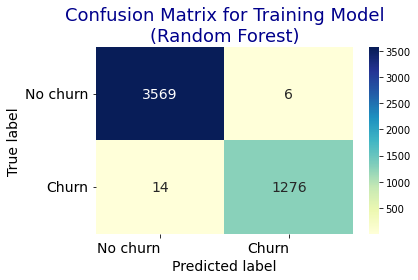

In [351]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Training Model\n(Random Forest)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

In [352]:
# Predict
y_test_pred = rdf_model.predict(x_test)

# Print classification report 
print('Classification Report Testing Model (Random Forest Classifier):')
print(classification_report(y_test, y_test_pred))

Classification Report Testing Model (Random Forest Classifier):
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1539
           1       0.60      0.47      0.53       546

    accuracy                           0.78      2085
   macro avg       0.71      0.68      0.69      2085
weighted avg       0.77      0.78      0.77      2085



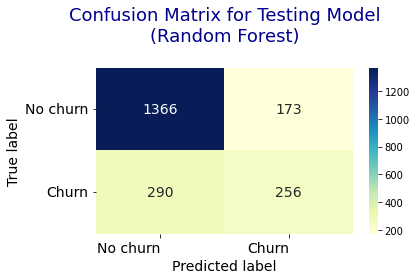

In [353]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Testing Model\n(Random Forest)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

* From the training data it can be seen that the model is able to predict the data by producing an accuracy of 100%
* From the data testing it can be seen that the model is able to predict the data by producing an accuracy of 78%

#### Gradient Boosting Classifier

In [354]:
gbt_model = GradientBoostingClassifier().fit(x_train, y_train)

In [355]:
# Train
y_train_pred = gbt_model.predict(x_train)

# Print classification report 
print('Classification Report Training Model (Gradient Boosting) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Gradient Boosting) :
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      3575
           1       0.70      0.54      0.61      1290

    accuracy                           0.82      4865
   macro avg       0.78      0.73      0.75      4865
weighted avg       0.81      0.82      0.81      4865



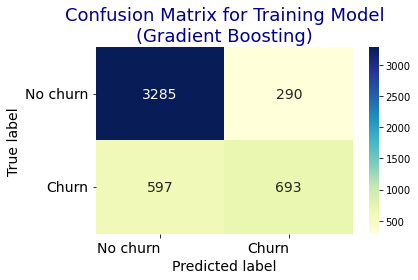

In [356]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Training Model\n(Gradient Boosting)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

In [357]:
# Predict
y_test_pred = gbt_model.predict(x_test) 

# Print classification report 
print('Classification Report Testing Model (Gradient Boosting):')
print(classification_report(y_test, y_test_pred))

Classification Report Testing Model (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1539
           1       0.66      0.49      0.56       546

    accuracy                           0.80      2085
   macro avg       0.75      0.70      0.72      2085
weighted avg       0.79      0.80      0.79      2085



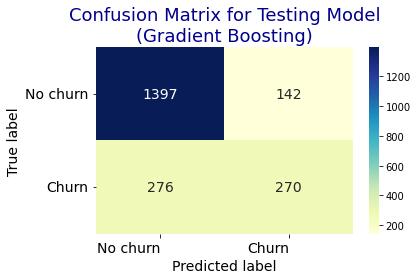

In [358]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test,y_test_pred)),('No churn', 'Churn'),('No churn','Churn'))
# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True,annot_kws={'size': 14}, fmt='d',cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0,ha='right',fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation=0,ha='right', fontsize=14)
plt.title('Confusion Matrix for Testing Model\n(Gradient Boosting)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.tight_layout()
plt.show()

* From the training data it can be seen that the model is able to predict the data by producing an accuracy of 82%
* From the data testing it can be seen that the model is able to predict the data by producing an accuracy of 80%

Based on the modeling that has been done, it can be concluded the best model is to use the Logistic Regression algorithm. This is because the performance of the Logistic Regression model tends to be able to predict equally well in the training and testing phases (80% training accuracy, 79% testing accuracy), on the other hand other algorithms tend to over-fit their performance.
However, this does not make us draw conclusions that if we use Logistic Regression to do any modeling, we still have to do a lot of model experiments to determine which one is the best.